# Libraries

In [70]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import pandas as pd

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

# %matplotlib ipympl
%matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [71]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_tx_dfe, rf_analog, tonegen

reload(calc)
reload(ofdm)
reload(rf_tx_dfe)
reload(rf_analog)
reload(tonegen)

<module 'rfdsppy.tonegen' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/tonegen.py'>

# Model

In [278]:
rng = np.random.default_rng()

ep = rng.uniform(low=-0.2, high=0.2)
theta = rng.uniform(low=-10*np.pi/180, high=10*np.pi/180)

print(f"Gain mismatch = {round(ep,5)}")
print(f"Phase mismatch = {round(theta*180/np.pi,2)} degrees")
print(f"Expected image suppression = {round(10*np.log10(4/(ep**2+theta**2)),2)}dBc")

iqup = rf_analog.IQUpconverter(ep=ep, theta=theta, mode="one-sided")

Gain mismatch = -0.1353
Phase mismatch = -1.47 degrees
Expected image suppression = 23.24dBc


EVM = 7.34%
SNR = 22.69dB


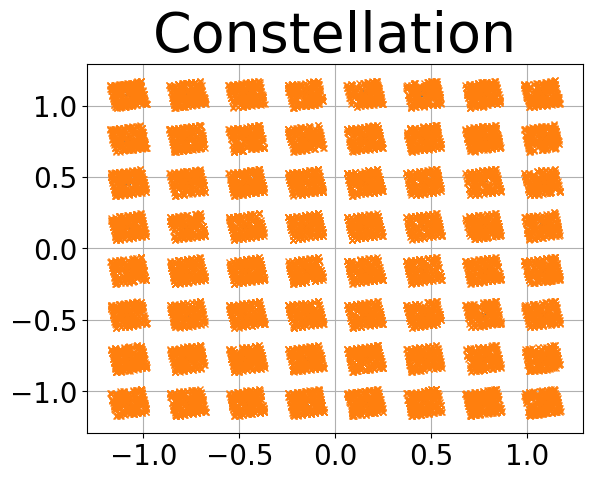

In [279]:
# Waveform params
en_tprecode = False
modorder = 64
wola = 0
bw = 20
scs = 15

wg = ofdm.OFDMWavGen(bw=bw, scs=scs, modorder=modorder, en_tprecode=en_tprecode, wola=wola)

# Generate waveform
x, x_standard = wg.generate(nsym=14)
cfg = wg.get_demod_params()
fs = cfg.get("fs")
wola_len = cfg.get("wola_len")

# Tx IQ mismatch model
y = iqup.transform(x)

evm = wg.calculate_evm(x_standard, y[round(wola_len/2):], en_plot=True)
print(f"EVM = {round(evm,2)}%")
print(f"SNR = {round(-20*np.log10(evm/100),2)}dB")

# Measurement

In [344]:
# Define the mismatch

rng = np.random.default_rng()

ep = rng.uniform(low=-0.2, high=0.2)
theta = rng.uniform(low=-10*np.pi/180, high=10*np.pi/180)

print(f"Gain mismatch = {round(ep,5)}")
print(f"Phase mismatch = {round(theta*180/np.pi,2)} degrees")
print(f"Expected image suppression = {round(10*np.log10(4/(ep**2+theta**2)),2)} dBc")

iqup = rf_analog.IQUpconverter(ep=ep, theta=theta, mode="balanced")

Gain mismatch = 0.02217
Phase mismatch = 8.34 degrees
Expected image suppression = 22.66 dBc


In [345]:
# This is the configuration for the measurement (for example)
# Use this to generate a realistic AWGN noise floor

modorder = 4
bw = 20
scs = 15
num_sc = 1200
start_sc = 600-round(num_sc/2)
en_tprecode = True
osr = 1
ofdm_wavgen = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr)
cfg = ofdm_wavgen.get_demod_params()
fs = cfg.get("fs")

awgn = rf_analog.AWGN(-30, bw, fs)

In [346]:
# Generate a complex tone, add AWGN, and estimate the mismatch

rng = np.random.default_rng()

fc = 5
nsamp = 2048
x = tonegen.tonegen(fs, fc, cossin="exp", theta0=rng.uniform(0,2*np.pi), nsamp=nsamp, power=0)

y = iqup.transform(x)
y = awgn.transform(y)

wc = fc*2*np.pi/fs
alpha = np.sum(y*np.exp(-1j*wc*np.arange(y.size)))
beta = np.sum(y*np.exp(1j*wc*np.arange(y.size)))
ab = alpha*beta

c2 = abs(ab.imag/ab.real)
c1 = alpha*alpha.conjugate()/(beta*beta.conjugate())

ep_est = np.sqrt(4/c1/(1+c2**2))
theta_est = ep_est*c2
ep_est = ep_est*np.sign(ab.real)
theta_est = theta_est*np.sign(ab.imag)
ep_est = ep_est.real
theta_est = theta_est.real

print(f"ep_est: {round(ep_est,5)}")
print(f"ep: {round(ep,5)}")
print(f"theta_est: {round(theta_est*180/np.pi,3)} degrees")
print(f"theta: {round(theta*180/np.pi,3)} degrees")
print(f"Expected image suppression = {round(10*np.log10(4/(ep**2+theta**2)),2)} dBc")

# rbw = fs/nsamp
# py, f = calc.psd(y, fs, rbw)
# px, _ = calc.psd(x, fs, rbw)
# # ps, f = calc.psd(x_standard,fs,rbw)
# fig = plt.figure()
# # plt.plot(f, 10*np.log10(ps))
# plt.plot(f, 10*np.log10(px), label="Input")
# plt.plot(f, 10*np.log10(py), label="Tx IQ Mismatch + AWGN")
# plt.title("PSD", {'fontsize':40})
# plt.xlabel("Frequency (MHz)", {'fontsize':30})
# plt.ylabel("PSD (dB/Bin)", {'fontsize':30})
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.autoscale(enable=True, axis='both', tight=True)
# plt.grid()
# plt.legend()
# plt.ylim(bottom=-100)

ep_est: 0.0219
ep: 0.02217
theta_est: 8.371 degrees
theta: 8.342 degrees
Expected image suppression = 22.66 dBc


# Compensation

Expected image suppression = 22.657677174548283 dBc
EVM = 0.04%
SNR = 68.87dB


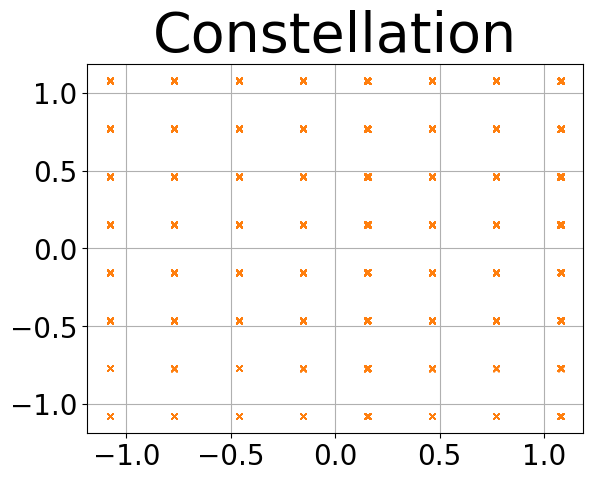

In [353]:
print(f"Expected image suppression = {10*np.log10(4/(ep**2+theta**2))} dBc")

iqup = rf_analog.IQUpconverter(ep=ep, theta=theta, mode="balanced")
tx_iqmc = rf_tx_dfe.TxIQMC(ep_est, theta_est, mode="one-sided")

# Waveform params
en_tprecode = False
modorder = 64
wola = 0
bw = 20
scs = 15

wg = ofdm.OFDMWavGen(bw=bw, scs=scs, modorder=modorder, en_tprecode=en_tprecode, wola=wola)

# Generate waveform
x, x_standard = wg.generate(nsym=14)
cfg = wg.get_demod_params()
fs = cfg.get("fs")
wola_len = cfg.get("wola_len")

# Tx IQ mismatch model
y = tx_iqmc.transform(x)
y = iqup.transform(y)

evm = wg.calculate_evm(x_standard, y[round(wola_len/2):], en_plot=True)
print(f"EVM = {round(evm,2)}%")
print(f"SNR = {round(-20*np.log10(evm/100),2)}dB")